In [1]:
import os

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# ignore warnings
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
#INPUT_FOLDER = os.path.join(".", "data")
INPUT_FOLDER = os.path.join("/", "kaggle", "input")

In [3]:
for dirname, _, filenames in os.walk(INPUT_FOLDER):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s5e10/sample_submission.csv
/kaggle/input/playground-series-s5e10/train.csv
/kaggle/input/playground-series-s5e10/test.csv


In [4]:
#BASE_PATH = INPUT_FOLDER
BASE_PATH = os.path.join(INPUT_FOLDER, "playground-series-s5e10") # for kaggle

DATA_FILE = os.path.join(BASE_PATH, "train.csv")
SUBMISSION_FILE = os.path.join(BASE_PATH, "test.csv")

In [5]:
TARGET = "accident_risk"

In [6]:
data = pd.read_csv(DATA_FILE)
data.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

In [8]:
data.describe()

,id,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
count,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000
mean,258876.500000,2.491511,0.488719,46.112575,1.187970,0.352377
std,149462.849974,1.120434,0.272563,15.788521,0.895961,0.166417
min,0.000000,1.000000,0.000000,25.000000,0.000000,0.000000
25%,129438.250000,1.000000,0.260000,35.000000,1.000000,0.230000
50%,258876.500000,2.000000,0.510000,45.000000,1.000000,0.340000
75%,388314.750000,3.000000,0.710000,60.000000,2.000000,0.460000
max,517753.000000,4.000000,1.000000,70.000000,7.000000,1.000000


In [9]:
data.isnull().sum()

id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64

## Análises

In [10]:
data.loc[data[TARGET] > 0.5, "high_chance"] = True
data.loc[data[TARGET] <= 0.5, "high_chance"] = False
data['high_chance'] = data['high_chance'].astype(bool)
data.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk,high_chance
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13,False
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35,False
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30,False
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21,False
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56,True


In [11]:
true_rows = data[data["high_chance"] == True]
false_rows = data[data["high_chance"] == False]

In [12]:
DEFAULT_SELECTED_COLS = ["road_type", "num_lanes", "speed_limit", "lighting", "weather", "road_signs_present", "public_road", "time_of_day", "holiday", "school_season"]

def plot_counting(data,selected_cols=DEFAULT_SELECTED_COLS):
    cols = 4
    n_selected_cols = len(selected_cols)
    rows = int(np.ceil(n_selected_cols/cols))
    
    fig,ax = plt.subplots(rows, cols, figsize=(30,15))
    
    current_selected_col = 0
    for i in range(rows):
        for j in range(cols):
            if(current_selected_col >= n_selected_cols):
                continue
            
            sns.countplot(data=data, x=selected_cols[current_selected_col], ax=ax[i,j])
            current_selected_col += 1
    
    plt.show()

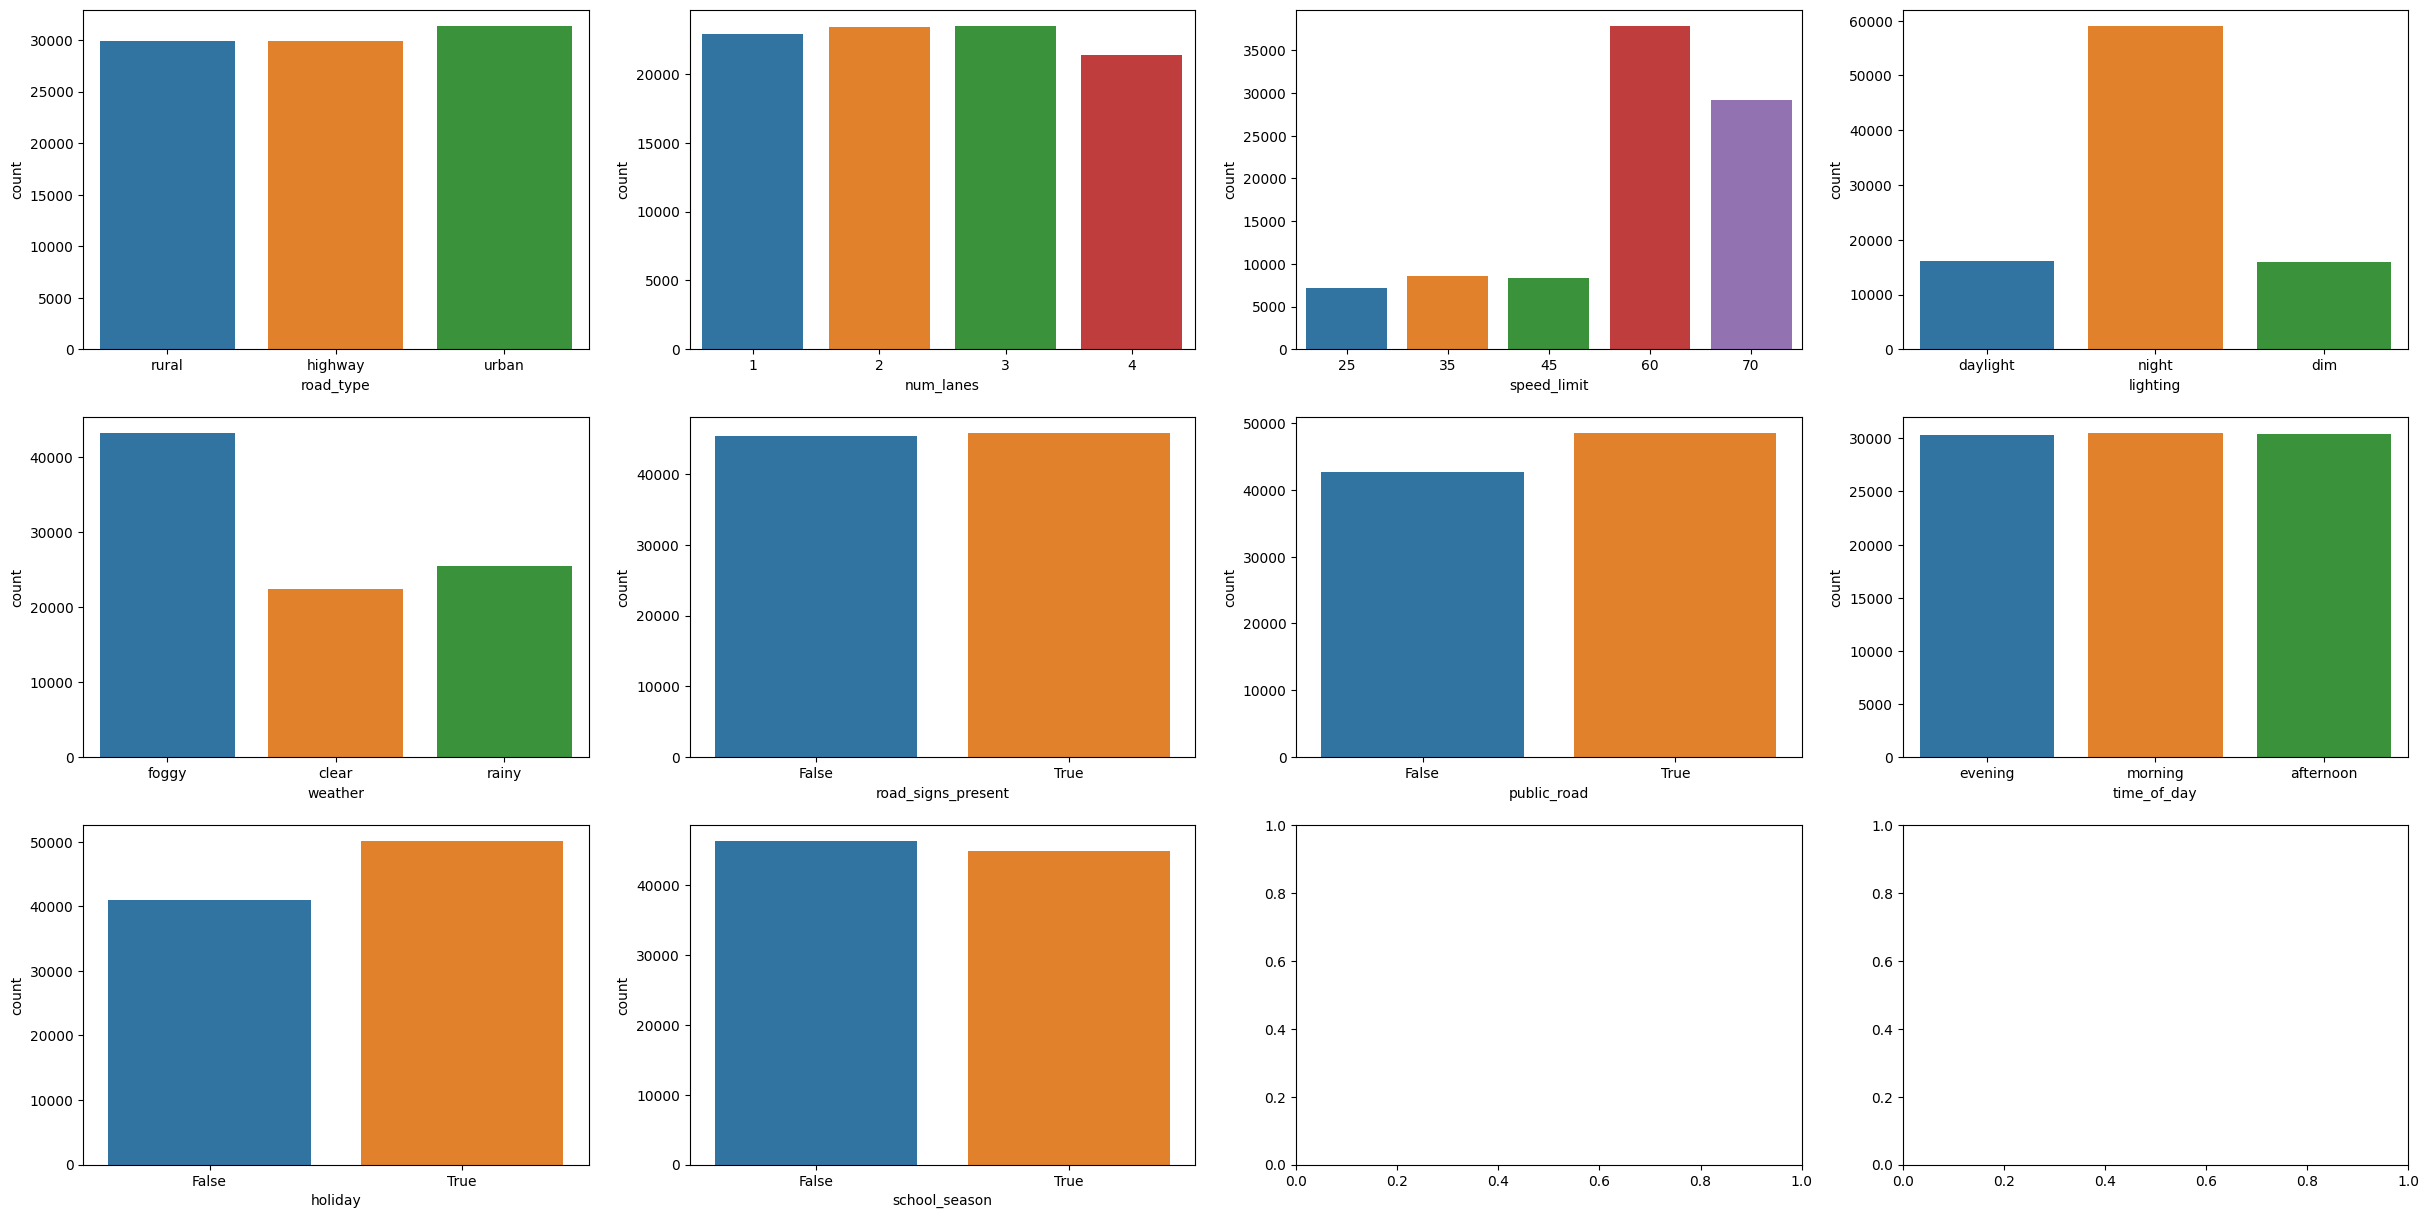

In [13]:
plot_counting(true_rows)

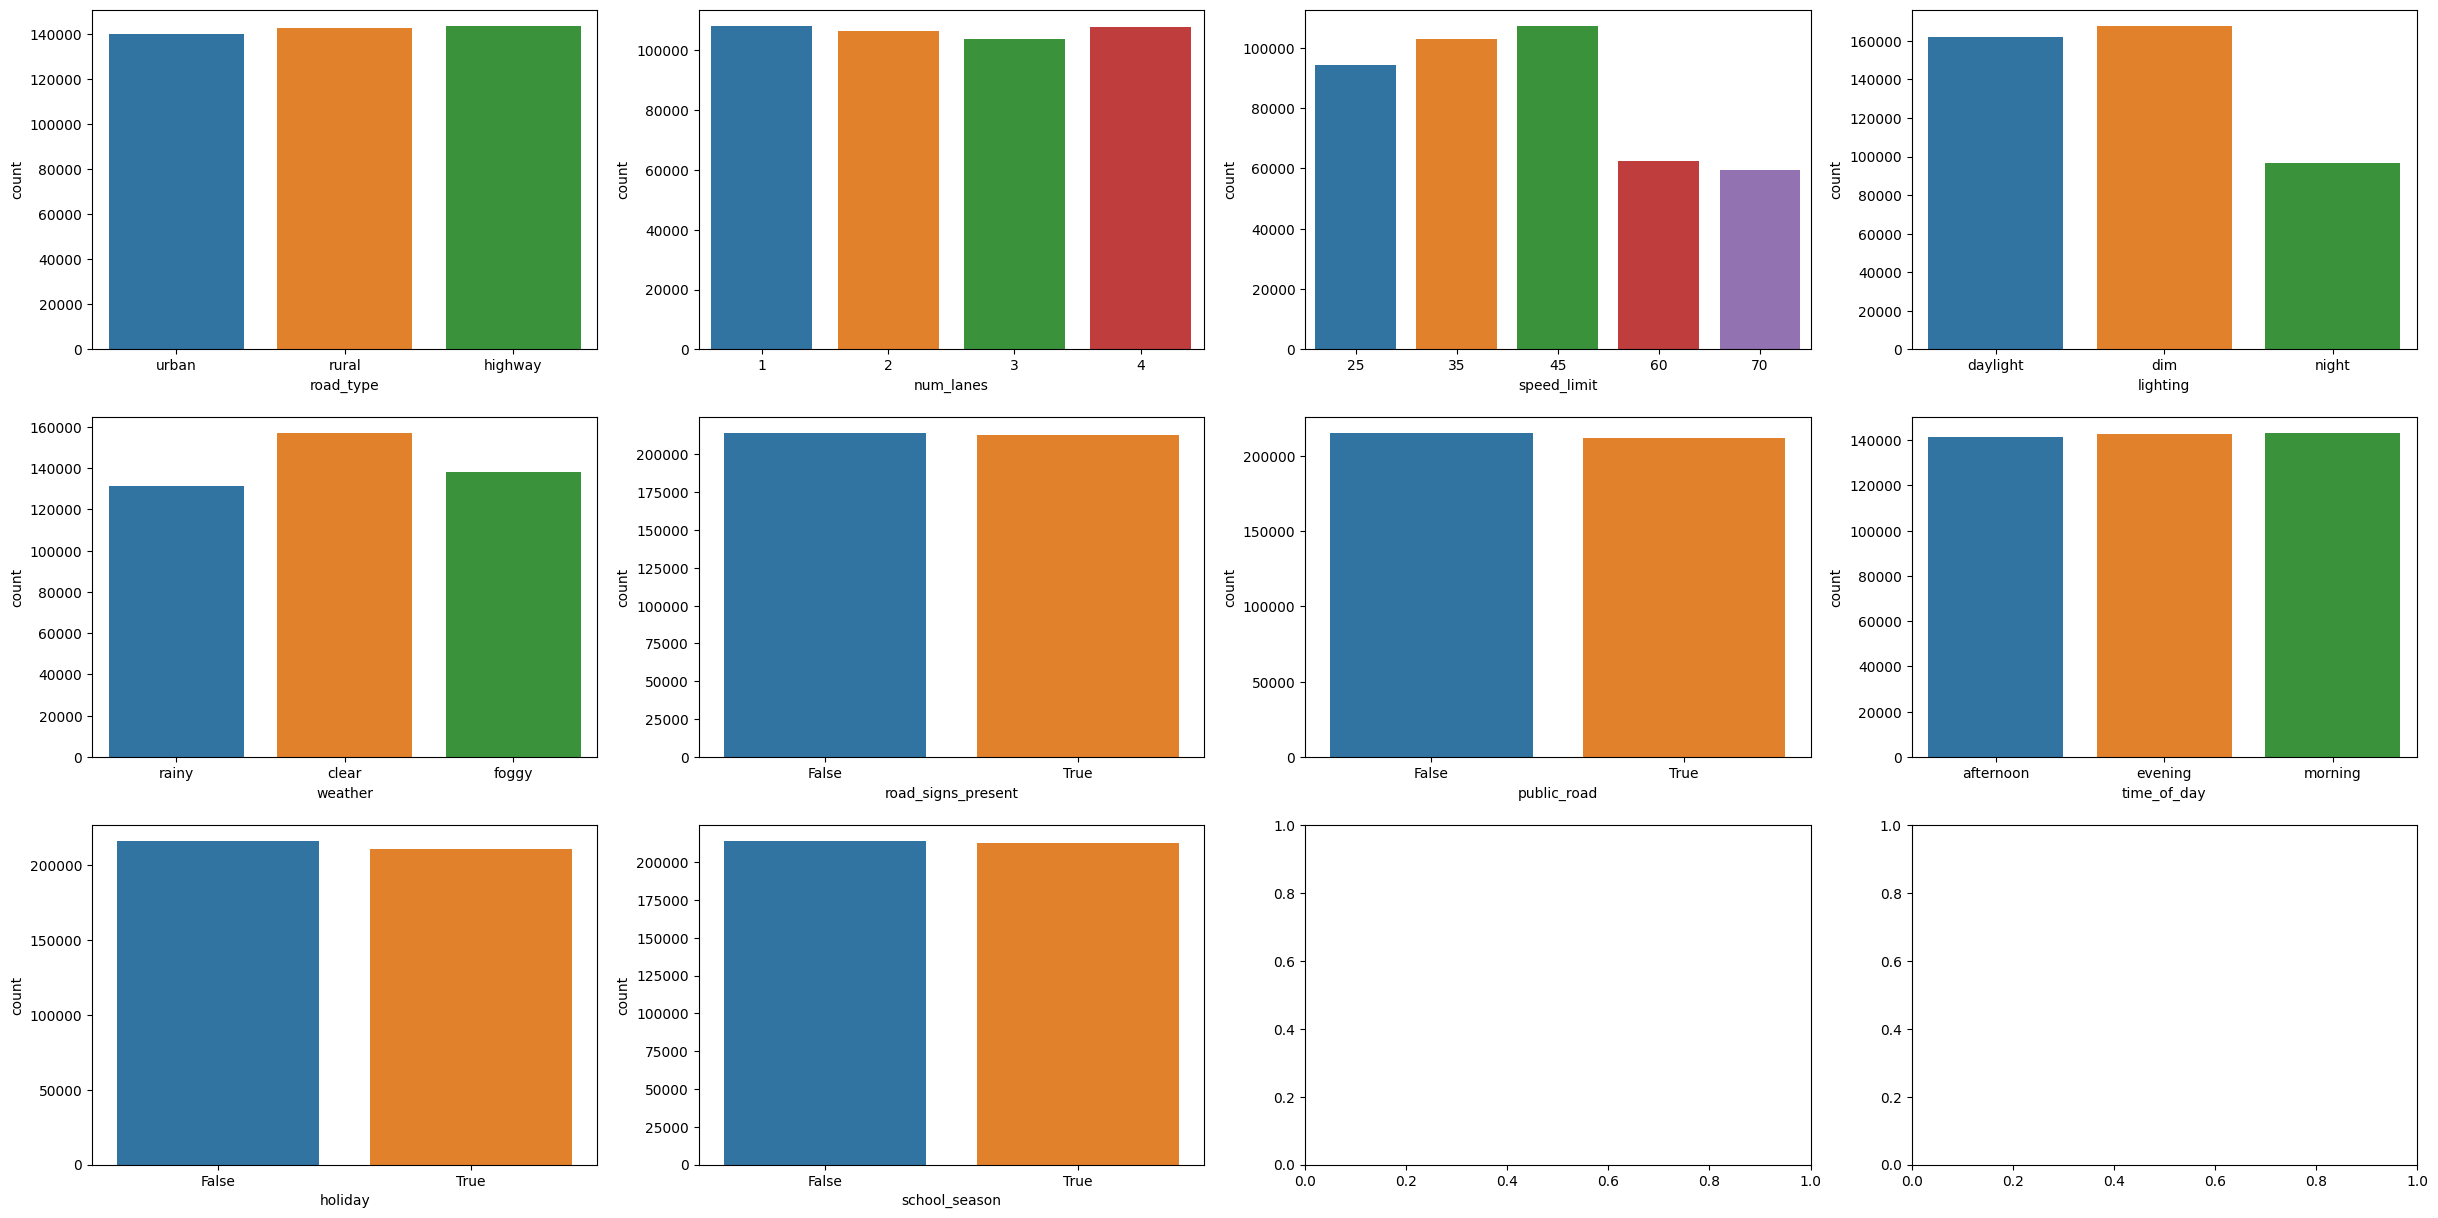

In [14]:
plot_counting(false_rows)

In [15]:
def plot_dist(data, selected_cols=DEFAULT_SELECTED_COLS, TARGET_col=TARGET):
    cols = 4
    n_selected_cols = len(selected_cols)
    rows = int(np.ceil(n_selected_cols/cols))
    
    fig,ax = plt.subplots(rows, cols, figsize=(30,15))
    
    current_selected_col = 0
    for i in range(rows):
        for j in range(cols):
            if(current_selected_col >= n_selected_cols):
                continue
            
            sns.histplot(data=data, x=TARGET_col, hue=selected_cols[current_selected_col], ax=ax[i,j], kde=True)
            current_selected_col += 1
    
    plt.show()

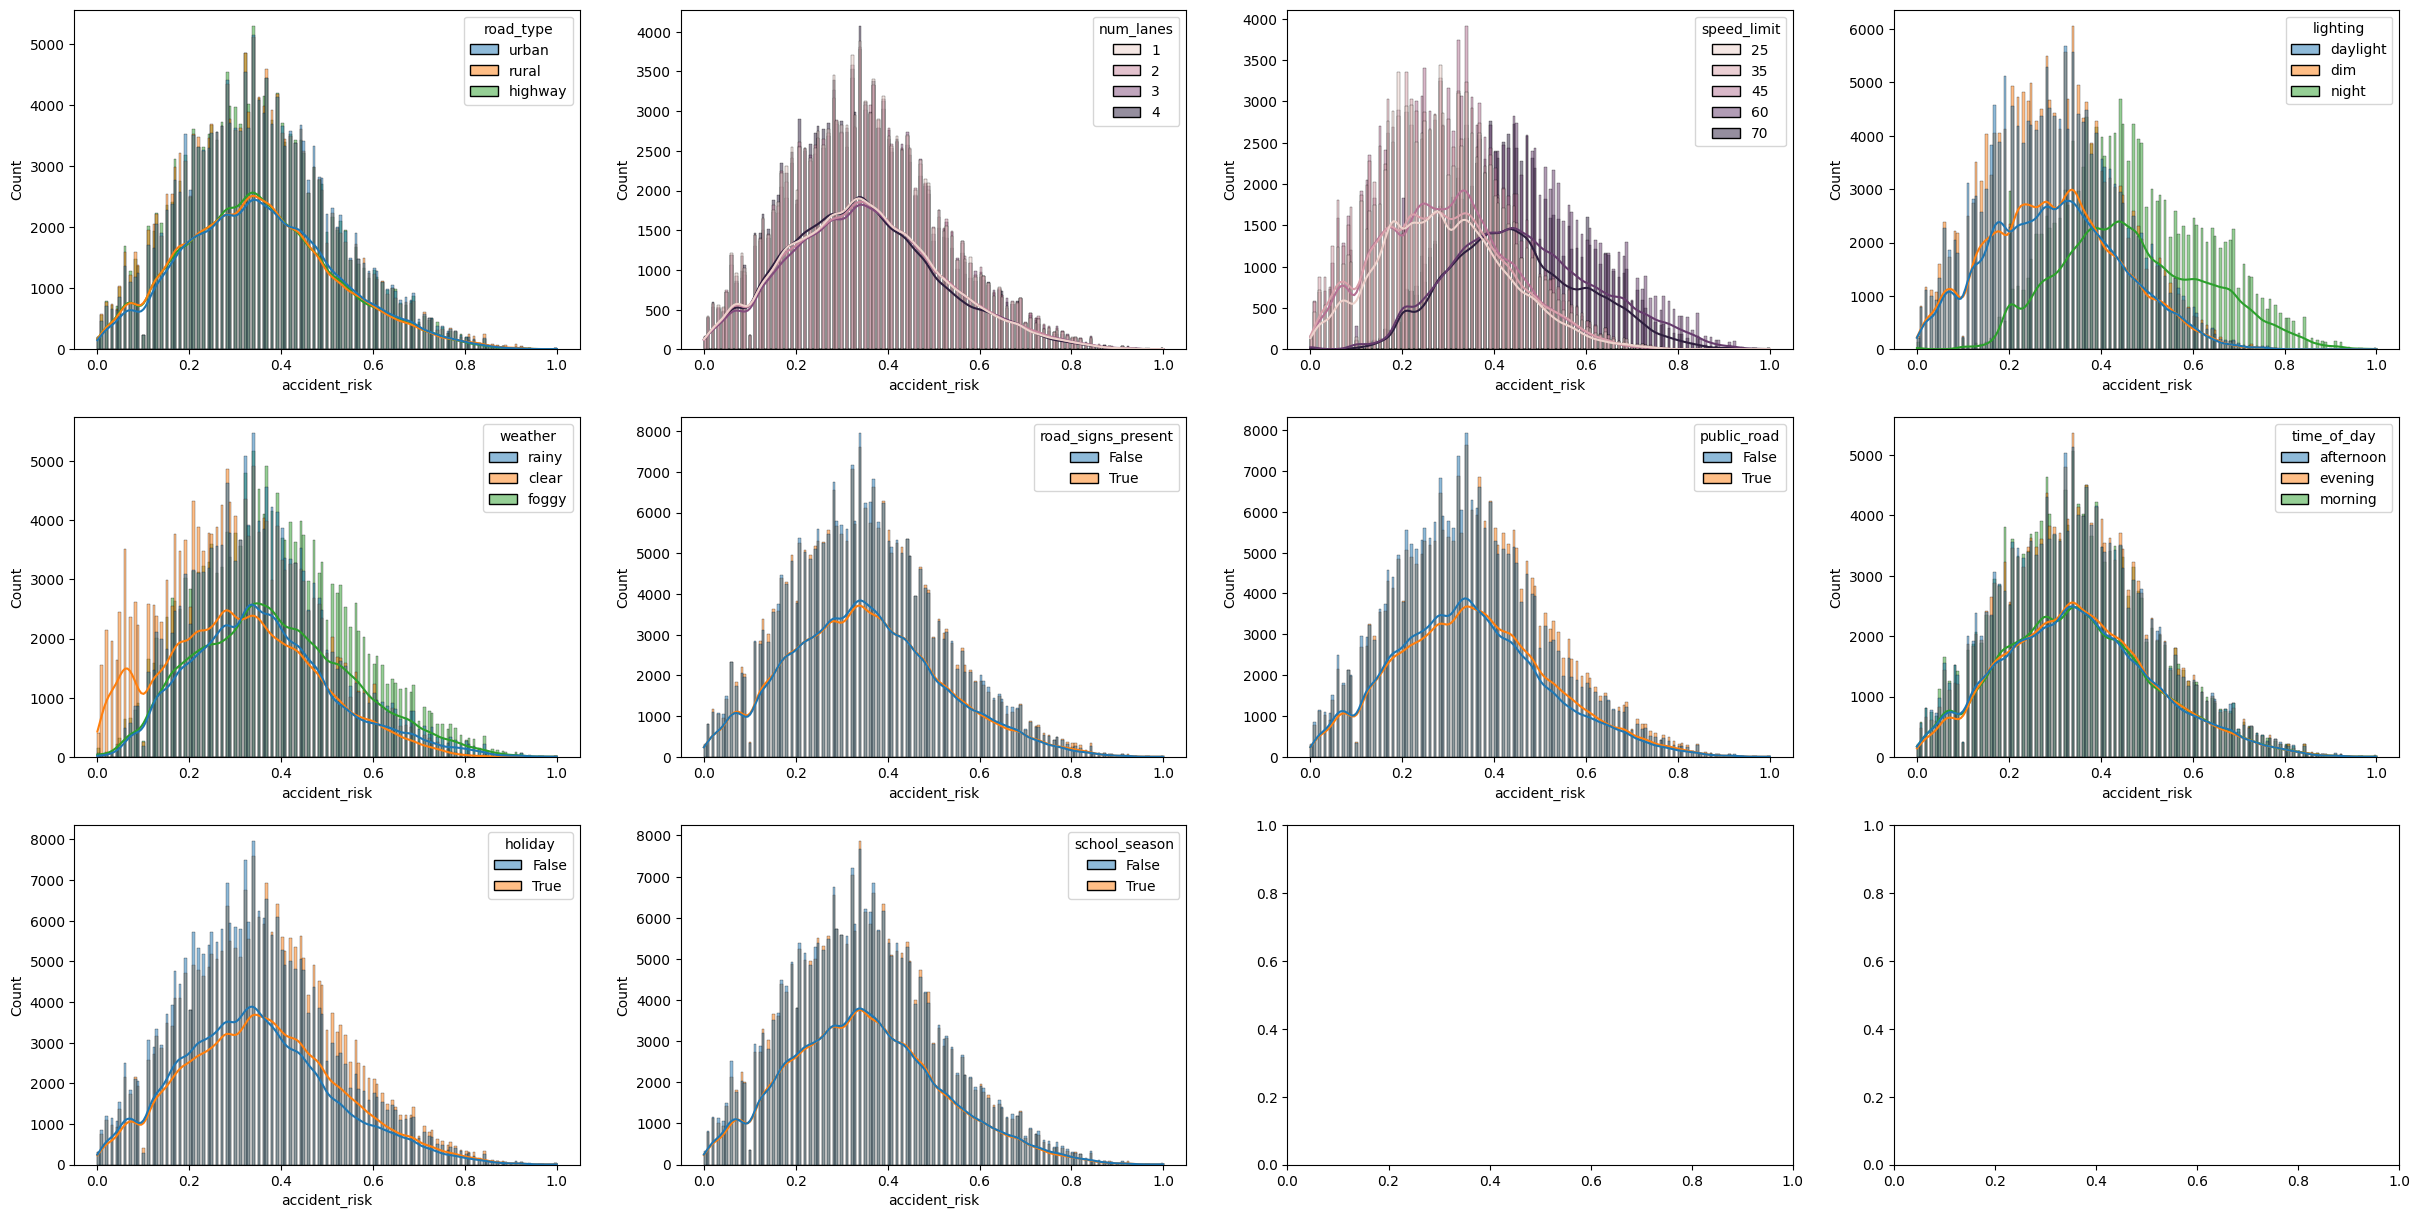

In [16]:
plot_dist(data)

In [17]:
data["is_night"] = 0
data.loc[data["lighting"] == "night", "is_night"] = 1
data["high_speed"] = 0
data.loc[data["speed_limit"] >= 60, "high_speed"] = 1

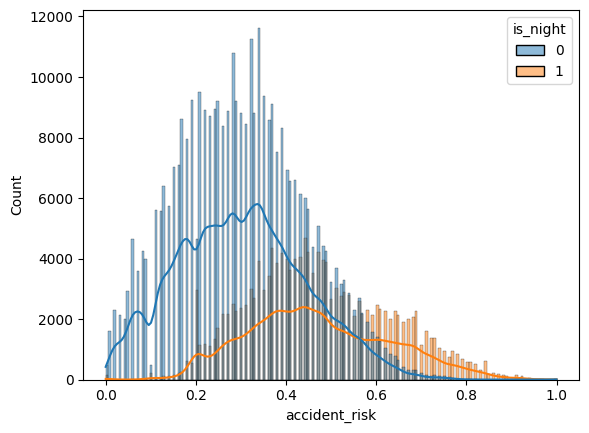

In [18]:
sns.histplot(data=data, x=TARGET, hue="is_night", kde=True)
plt.show()

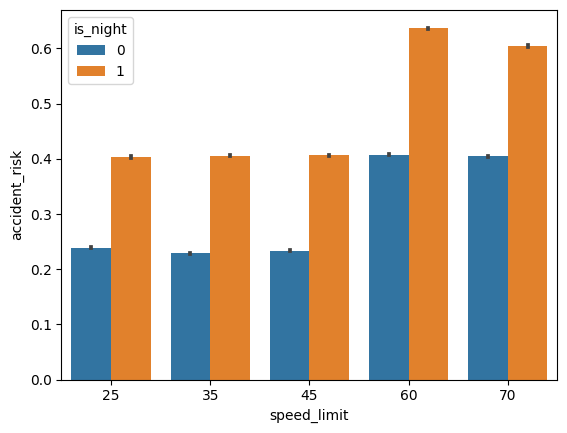

In [19]:
sns.barplot(data=data, x="speed_limit", y=TARGET, hue="is_night")
plt.show()

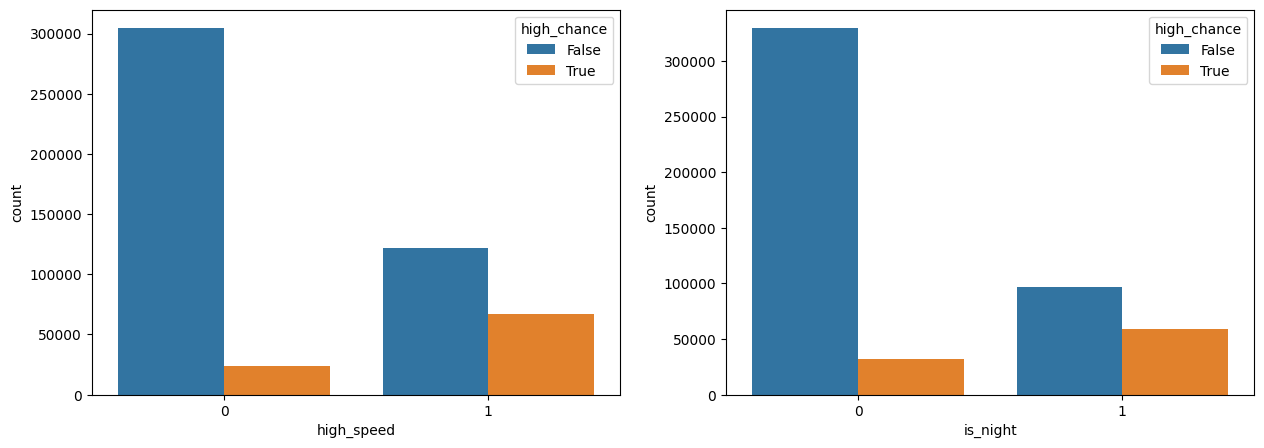

In [20]:
fig,ax = plt.subplots(1,2, figsize=(15,5))
sns.countplot(data=data, x="high_speed", hue="high_chance", ax=ax[0])
sns.countplot(data=data, x="is_night", hue="high_chance", ax=ax[1])
plt.show()

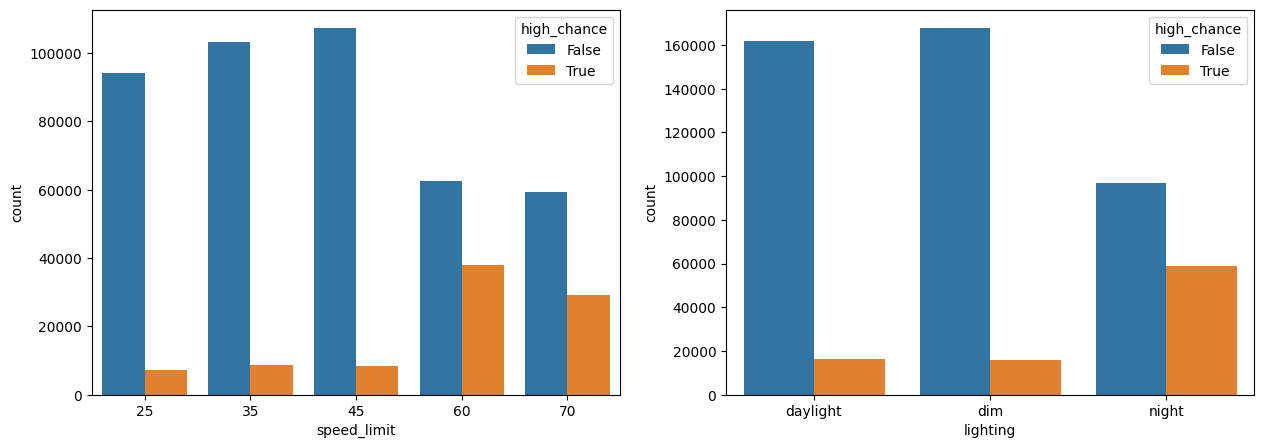

In [21]:
fig,ax = plt.subplots(1,2, figsize=(15,5))
sns.countplot(data=data, x="speed_limit", hue="high_chance", ax=ax[0])
sns.countplot(data=data, x="lighting", hue="high_chance", ax=ax[1])
plt.show()

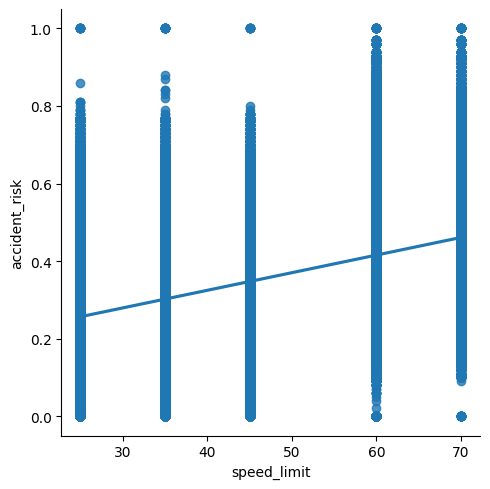

In [22]:
sns.lmplot(data=data, x="speed_limit", y=TARGET)
plt.show()

In [23]:
data["lighting"].unique()

array(['daylight', 'dim', 'night'], dtype=object)

In [24]:
data["weather"].unique()

array(['rainy', 'clear', 'foggy'], dtype=object)

In [25]:
mapped_values_lighting = {"daylight":0, "dim":1, "night":2}
mapped_values_weather = {"clear":0, "rainy":1, "foggy":2}
data["lighting_enc"] = data["lighting"].map(mapped_values_lighting)
data["weather_enc"] = data["weather"].map(mapped_values_weather)
data.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk,high_chance,is_night,high_speed,lighting_enc,weather_enc
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13,False,0,0,0,1
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35,False,0,0,0,0
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30,False,0,1,1,0
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21,False,0,0,1,1
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56,True,0,1,0,2


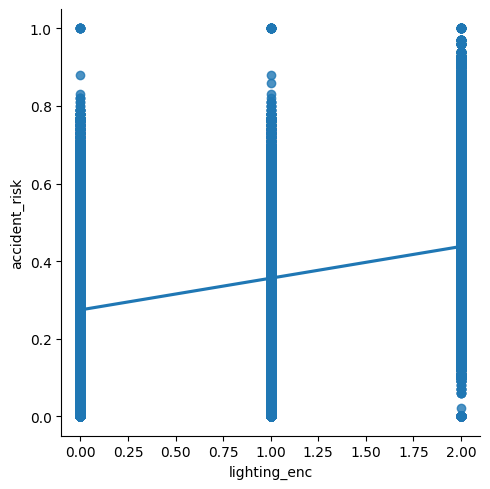

In [26]:
sns.lmplot(data=data, x="lighting_enc", y=TARGET)
plt.show()

[]

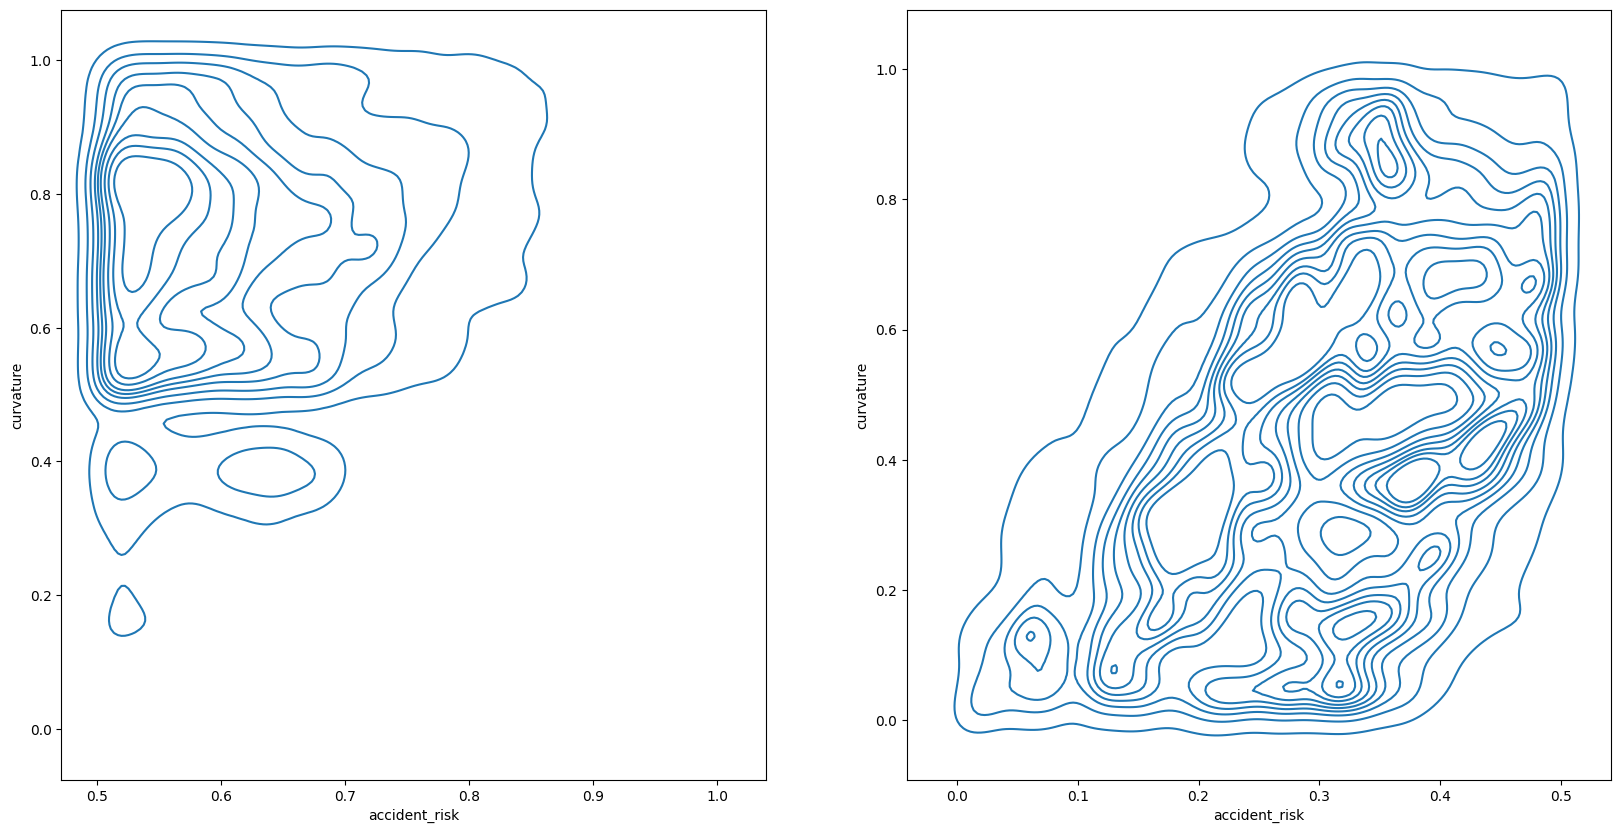

In [27]:
fig,ax=plt.subplots(1,2, figsize=(20,10))
sns.kdeplot(data=true_rows, x=TARGET, y="curvature",ax=ax[0])
sns.kdeplot(data=false_rows, x=TARGET, y="curvature",ax=ax[1])
plt.plot()

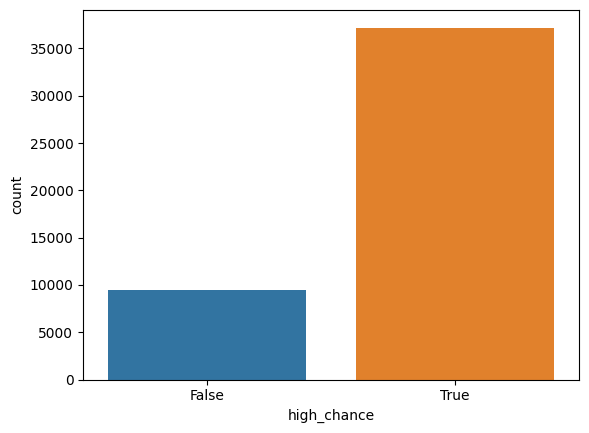

In [28]:
night_and_high_speed = data[(data["high_speed"] == 1) & (data["is_night"] == 1)]
sns.countplot(data=night_and_high_speed, x="high_chance")
plt.show()

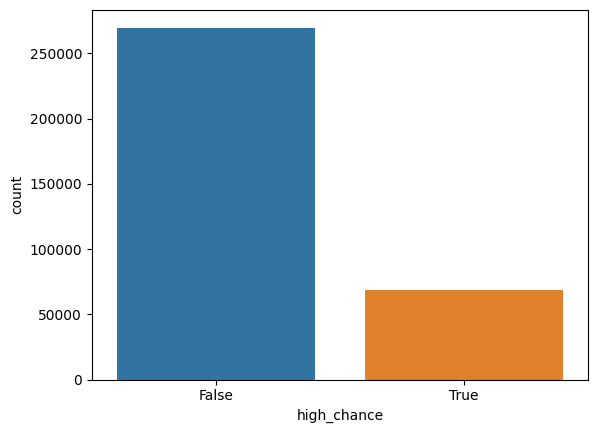

In [29]:
data["bad_weather"] = 1
data.loc[data["weather"] == "clear", "bad_weather"] = 0
bad_weather = data[data["bad_weather"] == 1]

sns.countplot(data=bad_weather, x="high_chance")
plt.show()

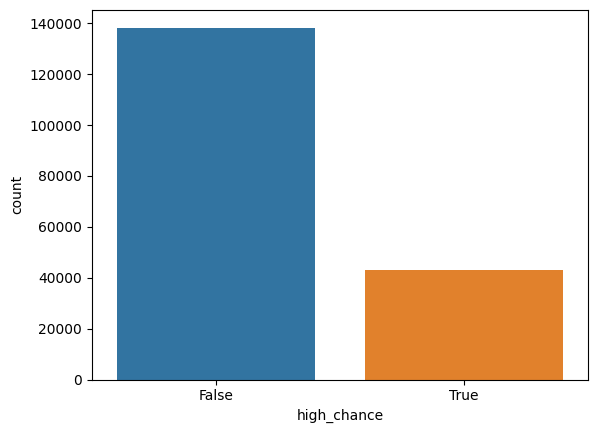

In [30]:
bad_weather = data[data["weather"] == "foggy"]
sns.countplot(data=bad_weather, x="high_chance")
plt.show()

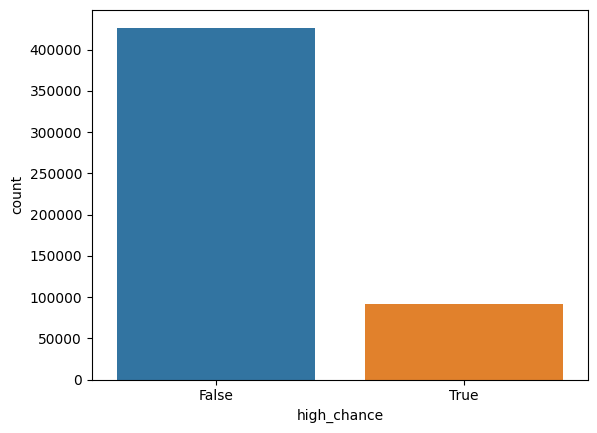

In [31]:
sns.countplot(data=data, x="high_chance")
plt.show()

In [32]:
data[(data["speed_limit"] == 70) & (data["lighting"] == "night")][TARGET].mean()

0.6050048137094446

In [33]:
def draw_matrix(x_col, y_col):
    y_labels = data[y_col].unique().tolist()
    x_labels = data[x_col].unique().tolist()
    
    n_rows = len(y_labels)
    n_cols = len(x_labels)
    data_matrix = np.zeros((n_rows,n_cols))
    
    fig, ax = plt.subplots(figsize=(20,20))
    
    for i,y in enumerate(y_labels):
        for j,x in enumerate(x_labels):
            val = data[(data[y_col] == y) & (data[x_col] == x)][TARGET].mean()
            data_matrix[i,j] = val
            ax.text(j,i, str(val), va='center', ha='center', color='white', fontsize=12)
    x_pos = np.arange(n_cols)
    y_pos = np.arange(n_rows)
    
    mat = ax.matshow(data_matrix,cmap='Purples')
    ax.set_xticks(x_pos, x_labels)
    ax.set_yticks(y_pos, y_labels)
    fig.colorbar(mat)
    plt.show()

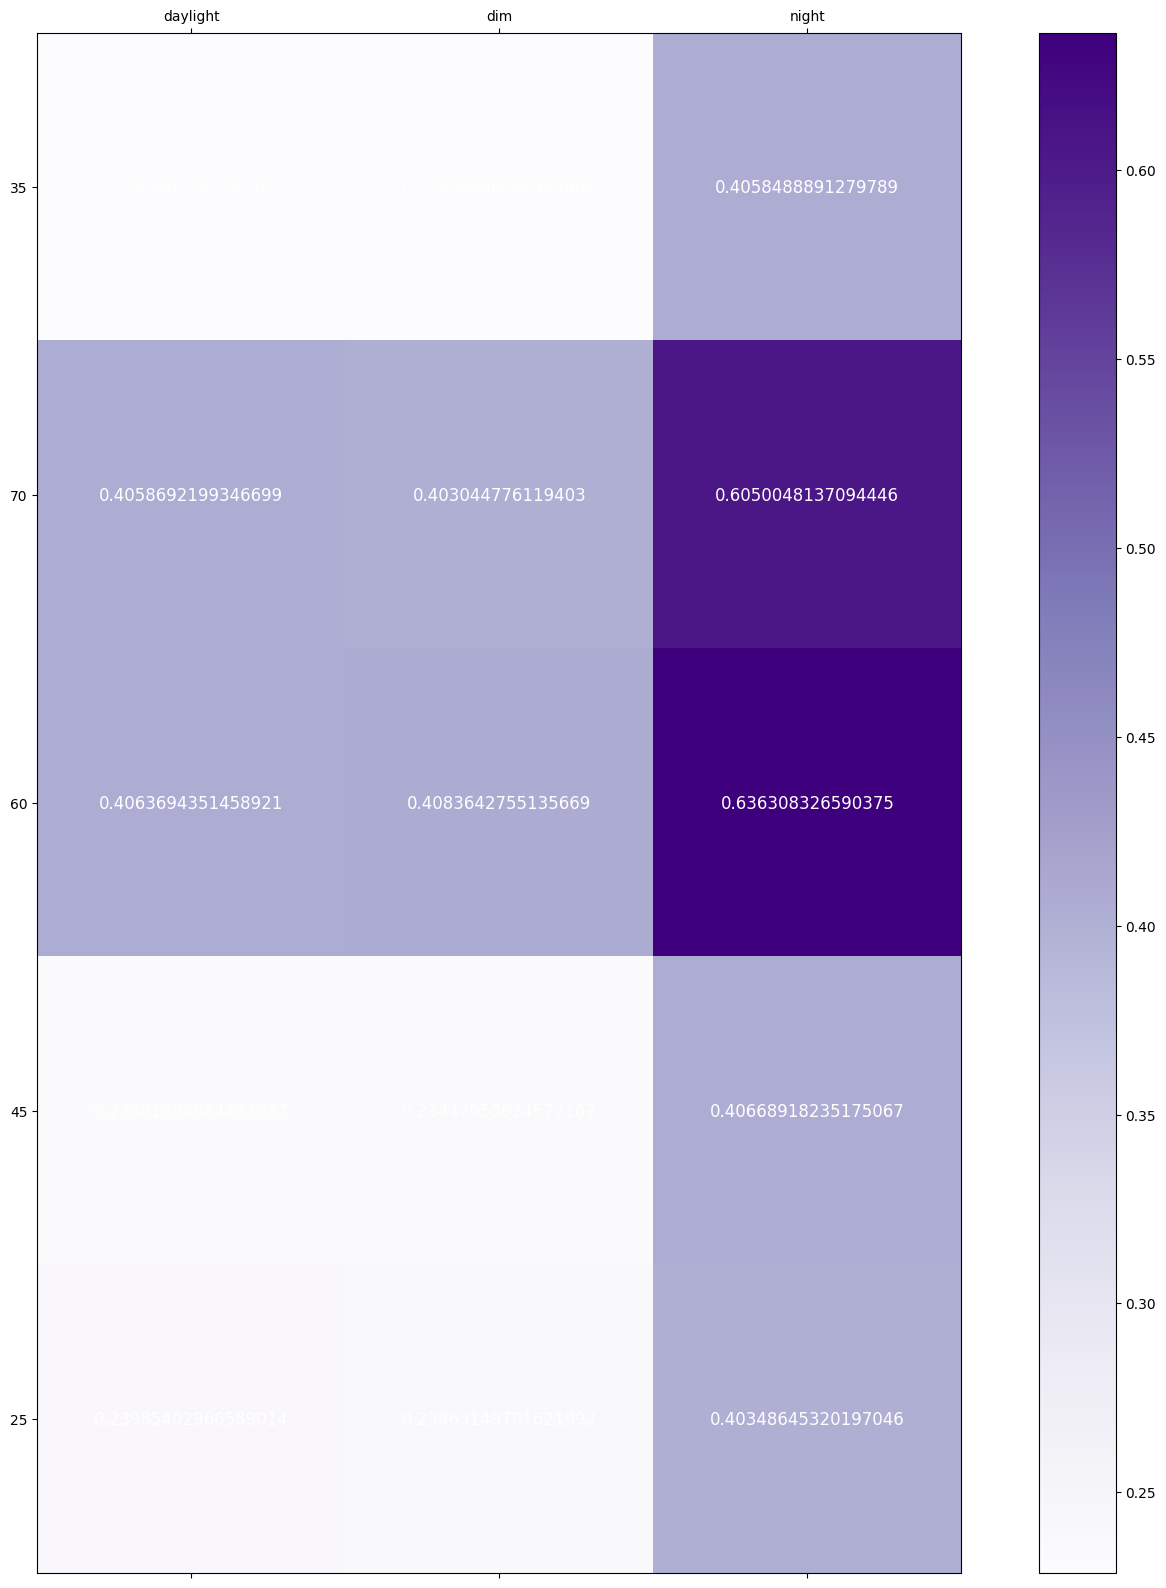

In [34]:
draw_matrix("lighting", "speed_limit")

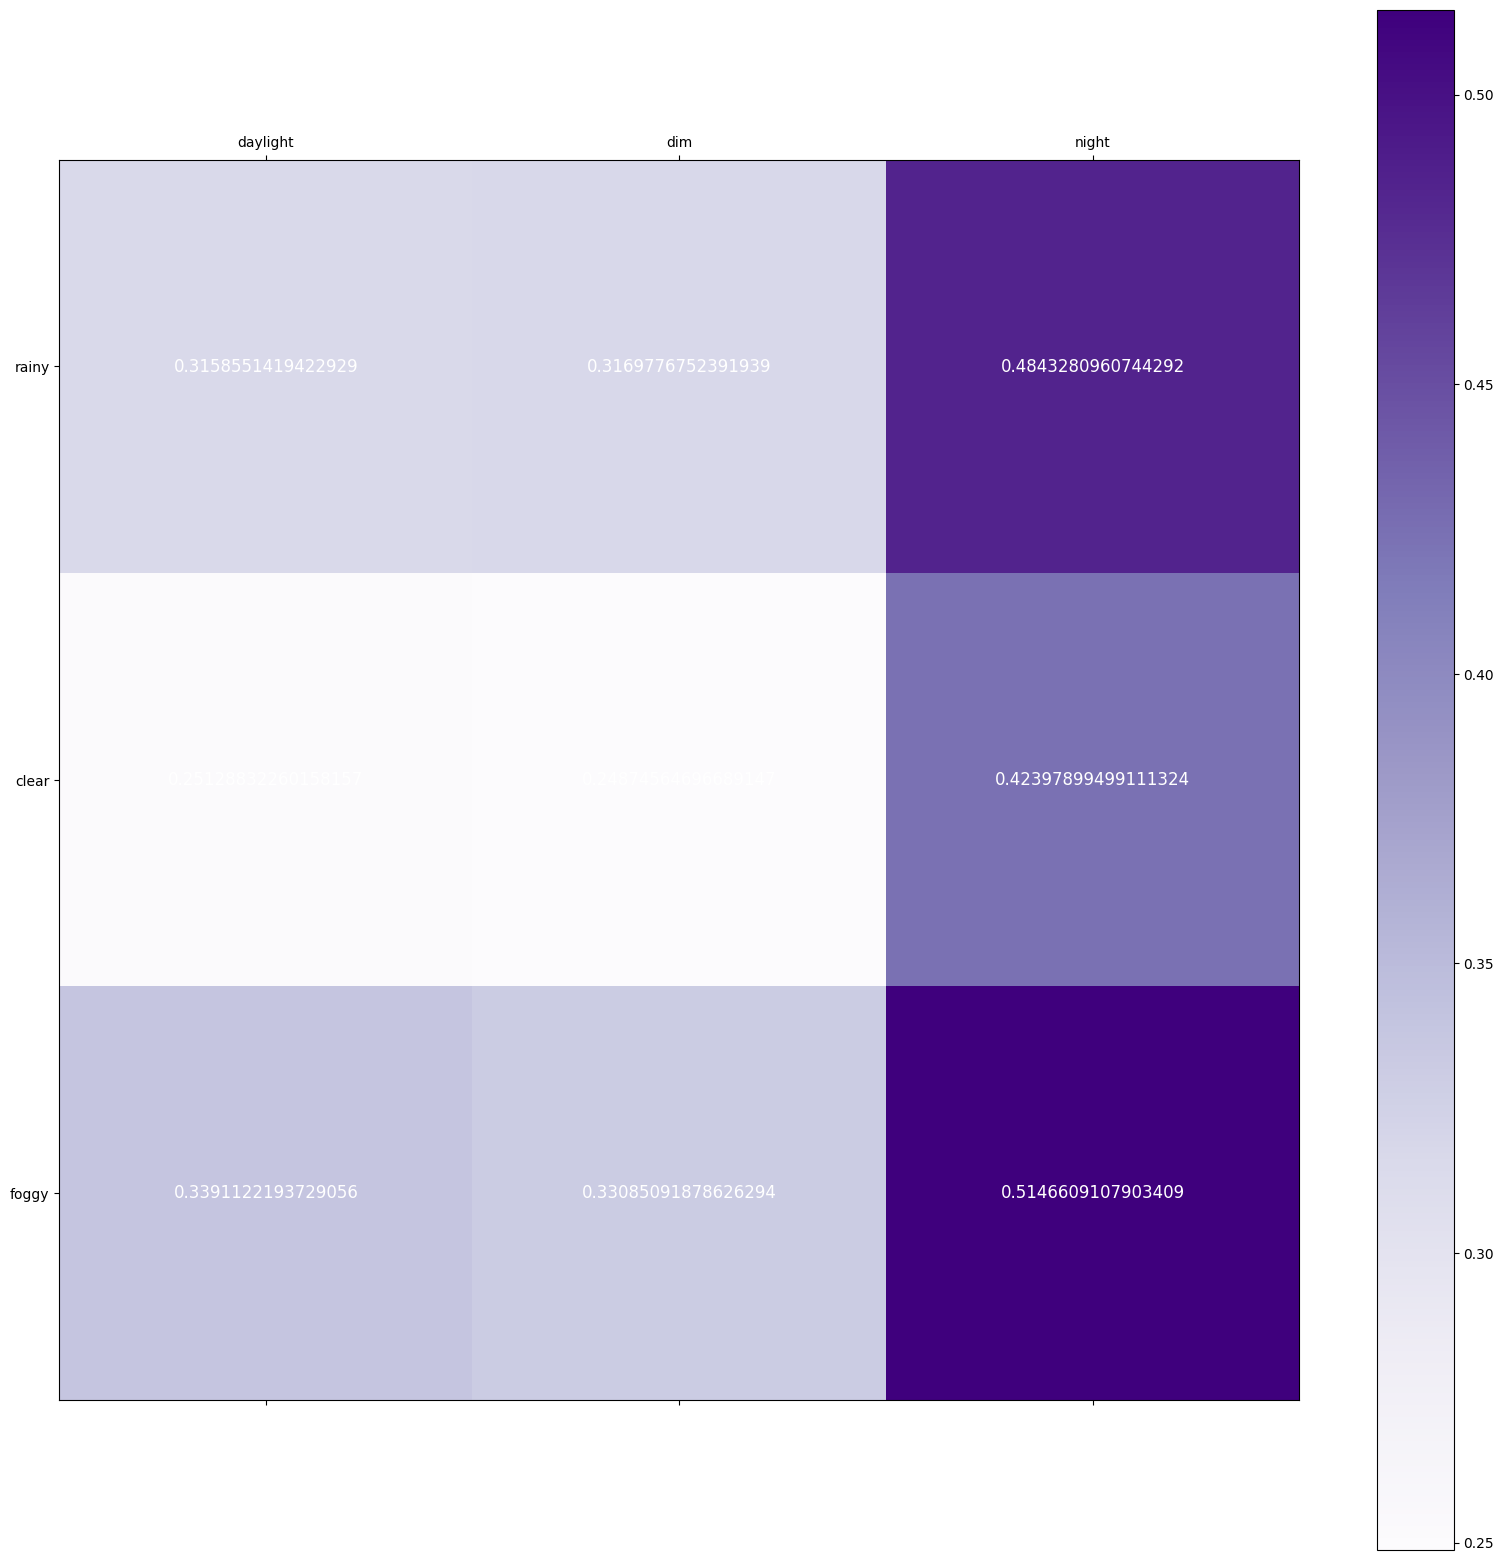

In [35]:
draw_matrix("lighting", "weather")

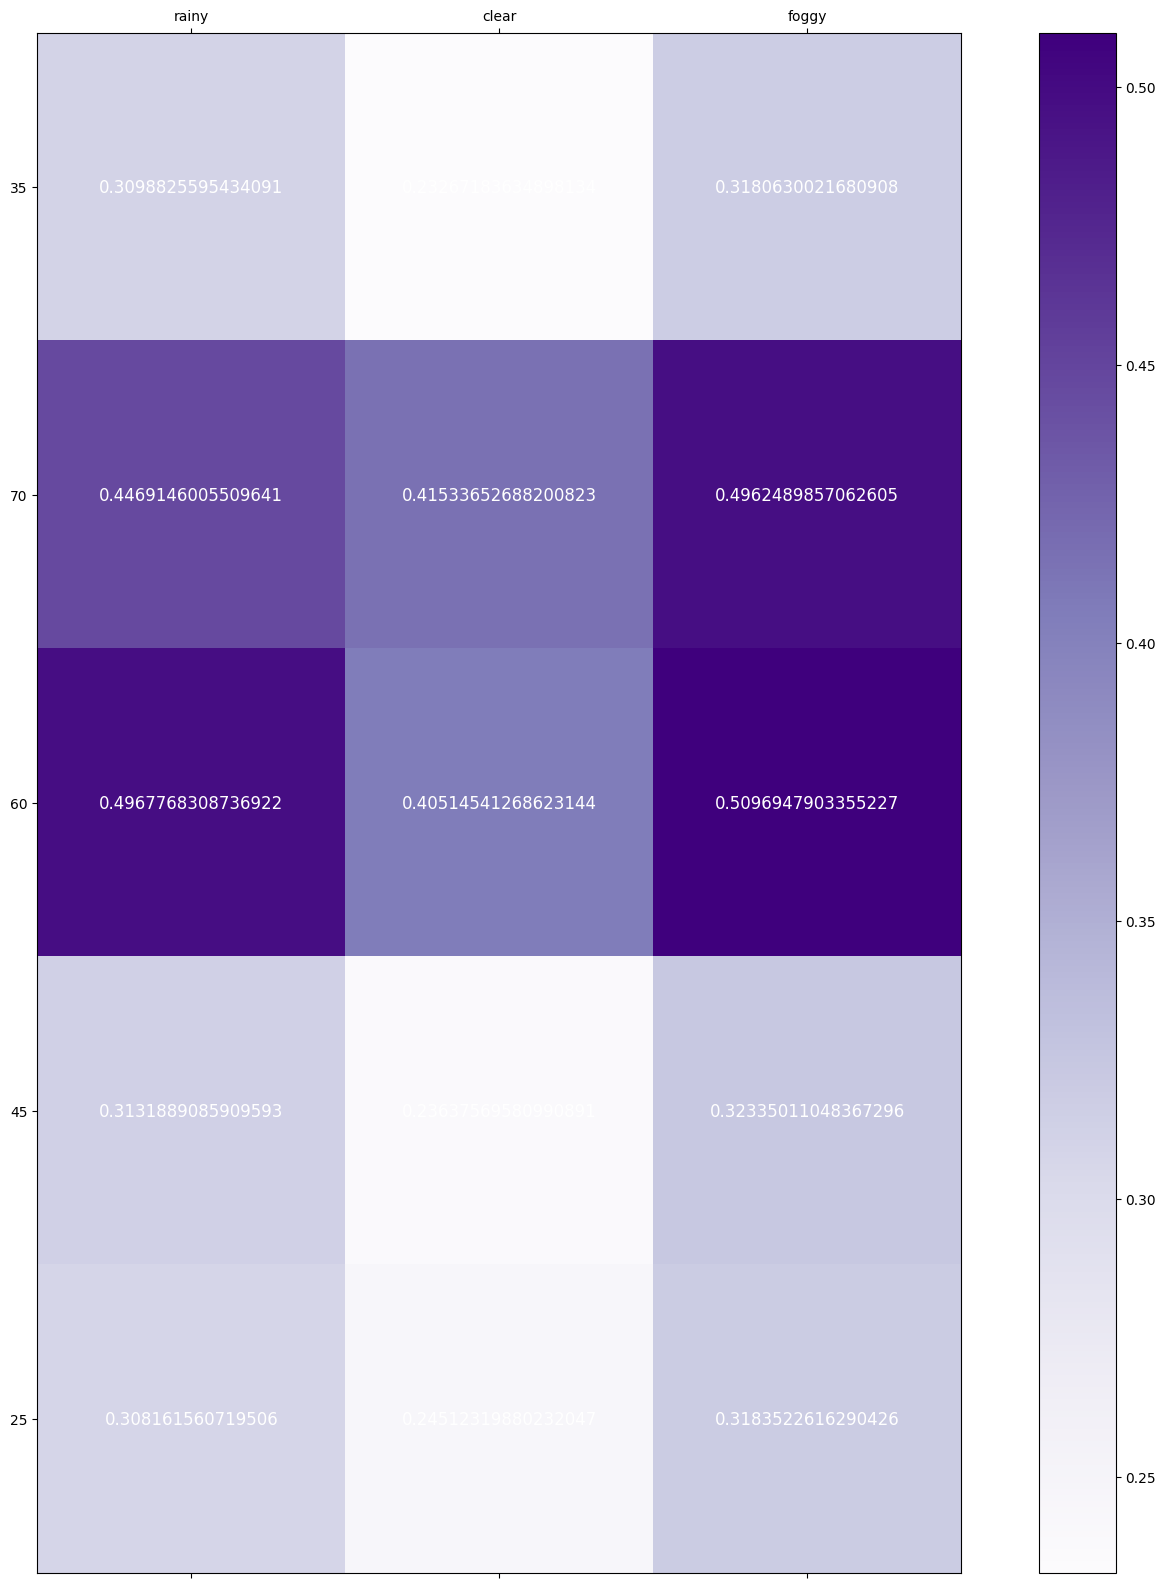

In [36]:
draw_matrix("weather","speed_limit")



# Modelo

In [37]:
features_set = [["speed_limit", "lighting_enc"], ["weather_enc", "speed_limit"], ["weather_enc", "lighting_enc"], ["speed_limit", "lighting_enc", "weather_enc"]]
best_model = None
best_mse = 1_000_000
best_features = None

for features in features_set:
    X = data[features]
    y = data[TARGET]
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
    
    tree = DecisionTreeRegressor()
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    error_tree = mean_squared_error(y_test, y_pred)
    
    linear = LinearRegression()
    linear.fit(X_train, y_train)
    y_pred = linear.predict(X_test)
    error_linear = mean_squared_error(y_test, y_pred)

    print("-"*30)
    print(features)
    print(f"MSE for Decision Tree: {error_tree}")
    print(f"MSE for Linear Regression: {error_linear}")

    if(error_tree < best_mse):
        best_mse = error_tree
        best_model = tree
        best_features = features
    elif(error_linear < best_mse):
        best_mse = error_linear
        best_model = linear
        best_features = features

------------------------------
['speed_limit', 'lighting_enc']
MSE for Decision Tree: 0.013786335518865009
MSE for Linear Regression: 0.017594861376539307
------------------------------
['weather_enc', 'speed_limit']
MSE for Decision Tree: 0.019598934377204752
MSE for Linear Regression: 0.02137430272837461
------------------------------
['weather_enc', 'lighting_enc']
MSE for Decision Tree: 0.020207590424089872
MSE for Linear Regression: 0.02213666640913404
------------------------------
['speed_limit', 'lighting_enc', 'weather_enc']
MSE for Decision Tree: 0.011596248703323512
MSE for Linear Regression: 0.01601696583329324


In [38]:
print(f"Best features: {best_features}; best error: {best_mse}")

Best features: ['speed_limit', 'lighting_enc', 'weather_enc']; best error: 0.011596248703323512


# Submissão

In [39]:
sub_data = pd.read_csv(SUBMISSION_FILE)
sub_data.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1
3,517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2
4,517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3


In [40]:
sub_data["lighting_enc"] = sub_data["lighting"].map(mapped_values_lighting)
sub_data["weather_enc"] = sub_data["weather"].map(mapped_values_weather)
sub_data.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,lighting_enc,weather_enc
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1,2,0
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0,1,2
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1,1,0
3,517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2,0,1
4,517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3,0,0


In [41]:
predictions = np.round(best_model.predict(sub_data[best_features]),decimals=3)
predictions

array([0.355, 0.264, 0.161, ..., 0.354, 0.266, 0.442])

In [42]:
submission = pd.DataFrame({
    "id":sub_data["id"],
    TARGET:predictions
})
display(submission.head())
submission.to_csv("submission.csv", index=False)

,id,accident_risk
0,517754,0.355
1,517755,0.264
2,517756,0.161
3,517757,0.257
4,517758,0.160
